In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates
from datetime import datetime, timedelta
import numpy as np

In [2]:
plt.rcParams.update({'figure.facecolor': 'white'})
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('planilhas/dados_anon.csv', encoding='utf8')
br_mun = pd.read_csv('BR_MUN.csv', sep=';')

In [4]:
def padronizacao_dados_geo(df):
    df['Cidade'] = df['Cidade'].str.upper() #remove caracteres especiais e joga tudo para maiúsculo
    carac_sub = {'Á':'A', 'À': 'A', 'Ã': 'A', 'Â': 'A',
                 'É': 'E', 'Ê': 'E', 'Í': 'I', 'Ó': 'O',
                 'Õ': 'O', 'Ô': 'O', 'Ú': 'U', 'Ç': 'C'}
    df = df.replace({'Cidade': carac_sub}, regex=True)
    df['Valor do Frete'].replace(0, np.nan, inplace=True)
    br_mun = pd.read_csv('BR_MUN.csv', sep=';')

    df['região'] = ['Sudeste' if x in ['MG','SP','RJ','ES']
                    else 'Nordeste' if x in['RN','CE', 'PE', 'PB', 'AL', 'PI', 'MA', 'SE', 'BA']
                    else 'Norte' if x in ['AM', 'PA','AP', 'RR', 'AC', 'RO', 'TO']
                    else 'Sul' if x in['PR', 'SC', 'RS']
                    else 'Centro-Oeste' if x in['MT', 'GO', 'MS', 'DF']
                    else '-' for x in df['Estado']]
    df['Data'] = pd.to_datetime(df['Data'])
    
    return df

In [5]:
def mostra_faturamento(df, data_inicial='2021-03-21', data_final=pd.to_datetime(datetime.today().date())):
    
    periodo = df[(df['Data']>=data_inicial) & (df['Data']<=data_final)]
    print('• O total faturado é de', 
        periodo['Subtotal'].loc[periodo['Status do Pagamento'] == 'Confirmado'].sum() - 
        periodo['Desconto'].loc[periodo['Status do Pagamento'] == 'Confirmado'].sum())


    print(str(round(periodo['Status do Pagamento'].loc[periodo['Status do Pagamento'] == 'Confirmado'].count() / 
                    len(periodo) * 100, 2)) + '%', 'dos pedidos foram confirmados')

In [6]:
mostra_faturamento(df, '2021-04-01', '2021-06-30')
mostra_faturamento(df, '2021-07-01', '2021-09-30')
mostra_faturamento(df, '2021-10-01', '2021-12-31')

• O total faturado é de 20757.7
69.49% dos pedidos foram confirmados
• O total faturado é de 27222.130000000005
79.66% dos pedidos foram confirmados
• O total faturado é de 34216.71
85.06% dos pedidos foram confirmados


In [7]:
def planilha_vendas(df, data_inicial=df['Data'].min(), data_final=df['Data'].max()):
    
    data_inicial = pd.to_datetime(data_inicial)
    data_final = pd.to_datetime(data_final)
    df['Data'] = pd.to_datetime(df['Data'])
    df = df[(df['Data']>=data_inicial) & (df['Data']<=data_final)]
    
    pagamento_conf = df['Status do Pagamento'] == 'Confirmado'
    df = df.loc[pagamento_conf]
    filtro = [x in zip(br_mun['Cidade'], br_mun['Estado']) for x in zip(df['Cidade'], df['Estado'])]
    df = df.loc[filtro] # remove distritos de muriae e evita erros
    df.reset_index(drop=True, inplace=True)

    df['Data de pagamento'] = pd.to_datetime(df['Data de pagamento'])
    df['ano'] = df['Data de pagamento'].dt.year
    df['trimestre'] = df['Data de pagamento'].dt.quarter
    df['mes'] = df['Data de pagamento'].dt.month
    df['semana'] = df['Data de pagamento'].dt.isocalendar().week
    df['dia'] = df['Data de pagamento'].dt.day
    df['dia da semana'] = df['Data de pagamento'].dt.weekday
    
    return df

In [8]:
def periodo_de_exercicio(df, ano=2021, periodo='trimestre', col='Subtotal', save=False):
    
    df = df[df['ano']==ano].select_dtypes('number')
    if periodo in ['trimestre', 'mes', 'semana', 'dia da semana', 'dia']:
        df = df.groupby(periodo).sum()
        
        fig = (plt.figure(figsize=(12,10)),
        plt.bar(df.index, df[col]),
        plt.title(f'Faturamento por {periodo} no ano de {ano}'),
        plt.ylabel('Faturamento'),
        plt.xlabel(f'{periodo}'))
        
    else:
        print('periodo inválido para cálculos')
    if save:
        plt.savefig(f'graficos/{ano}-fat-por-{periodo}-{col}')
    
    
    return fig

### Dados agregados por <strong> CÓDIGO IBGE</strong> do município

In [9]:
def agregacao_por_municipio(df, save=False):
    df['CD_IBGE'] = [br_mun.loc[u, 'CODIGO IBGE']
                for cid_est in zip(df['Cidade'], df['Estado'])
               for u, cid_est2 in enumerate(zip(br_mun['Cidade'], br_mun['Estado']))
               if cid_est == cid_est2]

    por_cidade = df[['CD_IBGE', 'Subtotal']].groupby('CD_IBGE').sum('Subtotal')
    por_cidade['Parcela Relativa'] = round(por_cidade['Subtotal'] / df['Subtotal'].sum() * 100, 2)
    por_cidade.reset_index(inplace=True)
    contagem = df[['CD_IBGE','Subtotal']].groupby('CD_IBGE', as_index=False).count()
    por_cidade['contagem'] = contagem['Subtotal']
    por_cidade['ticket medio'] = round(por_cidade['Subtotal'] / por_cidade['contagem'], 2)
    frete_m = df[['CD_IBGE', 'Valor do Frete']].groupby('CD_IBGE', as_index=False).mean()
    por_cidade['frete medio'] = round(frete_m['Valor do Frete'], 2)

    por_cidade.insert(1, 'Cidade', '')
    por_cidade.insert(2, 'Estado', '')

    cidades = [br_mun.loc[i, 'Cidade'] for i, cd in enumerate(br_mun['CODIGO IBGE'])
                           for cd2 in por_cidade['CD_IBGE'] if cd == cd2]
    estados = [br_mun.loc[i, 'Estado'] for i, cd in enumerate(br_mun['CODIGO IBGE'])
                           for cd2 in por_cidade['CD_IBGE'] if cd == cd2]
    por_cidade['Cidade'], por_cidade['Estado'] = cidades, estados
    if save:
        por_cidade.to_csv('planilhas/df_cidades.csv',
                          encoding='utf8', sep=';', float_format='%.2f', index=False)
    pd.set_option('display.max_rows', len(por_cidade))
    return por_cidade.sort_values('Parcela Relativa', ascending=False, ignore_index=True)

In [10]:
def agregacao_por_estado(df, data_inicial=df['Data'].min(), data_final=df['Data'].max(), save=False):
    
    data_inicial = pd.to_datetime(data_inicial)
    data_final = pd.to_datetime(data_final)
    df['Data'] = pd.to_datetime(df['Data'])
    df = df[(df['Data']>=data_inicial) & (df['Data']<=data_final)]
    
    por_estado = df[['Estado', 'Subtotal']].groupby('Estado').sum('Subtotal')
    por_estado['Parcela Relativa'] = round(por_estado['Subtotal'] / df['Subtotal'].sum() * 100,2)
    por_estado.reset_index(inplace=True)
    por_estado.sort_values(by=['Parcela Relativa'], ascending=False, ignore_index=True)

    contagem = df[['Estado','Subtotal']].groupby('Estado', as_index=False).count()
    por_estado['contagem'] = contagem['Subtotal']
    por_estado['ticket medio'] = round(por_estado['Subtotal'] / por_estado['contagem'], 2)
    frete_m = round(df[['Estado', 'Valor do Frete']].groupby('Estado', as_index=False).mean(), 2)
    por_estado['frete medio'] = frete_m['Valor do Frete']
    
    df = por_estado
    
    if save:
        por_estado.to_csv(f'planilhas/df_estados-{data_inicial.date()}a{data_final.date()}.csv',
                      encoding='utf8', index=False, float_format='%.2f')
    
    return df

In [11]:
def benchmark_cidades(df, col='Subtotal', save=False):
    try:
        df = por_cidade.sort_values(col, ascending=False, ignore_index=True)
        plt.figure(figsize=(10, 10))
        plt.barh(df['Cidade'][:15], df[col][:15])
        plt.xlabel(f'{col}')
        
        if save:
            plt.savefig(f'graficos/top_cidades_{col}.png')
            
    except:
        print(f'Verifique se a coluna existe em: {por_cidade.columns.to_list()}')

### Vendas diárias

In [12]:
 def vendas_df(df):
    df = df.groupby('Data de pagamento').agg({'Subtotal': 'sum',
                                'Desconto': 'sum',
                                'Número do Pedido': 'count'}).rename({'Número do Pedido': 'volume'}, axis=1)
    inicio, hoje = df.index.min(), df.index.max()
    
    intervalo = pd.DataFrame(data={'Data':pd.date_range(inicio, hoje)})

    df.reset_index(inplace=True)
    
    df['Data de pagamento'] = pd.to_datetime(df['Data de pagamento'])

    df = intervalo.merge(df, right_on='Data de pagamento', left_on='Data', how='left').fillna(0)
    df.drop('Data de pagamento', axis=1, inplace=True)
    return df

In [13]:
#por_dia.drop('Data de pagamento', axis=1)
def analise_vendas_diarias(df, data_inicial=df['Data'].min(), data_final=df['Data'].max(), 
                           save=False, ticks=10):

    data_inicial = pd.to_datetime(data_inicial)
    data_final = pd.to_datetime(data_final)
    df['Data'] = pd.to_datetime(df['Data'])
    df = df[(df['Data']>=data_inicial) & (df['Data']<=data_final)]
    
    media_diaria = np.mean(df['Subtotal'])
    acima_media = np.maximum(df['Subtotal'] - media_diaria, 0)
    abaixo_media = np.minimum(df['Subtotal'], media_diaria)
    
    plt.figure(figsize=(12, 10), facecolor='#363636'),
    
    ax = plt.axes()
    ax.set_title('Vendas diárias', color='white')
    ax.set(facecolor='#363636')
    ax.bar(df['Data'], df['Subtotal'], color='red')
    ax.bar(df['Data'], acima_media, color='orange', bottom=abaixo_media)
    ax.plot([data_inicial, data_final], [media_diaria, media_diaria], 'k--', color='royalblue', label='Média')
    plt.xticks(df['Data'][::-ticks], rotation=45, color='white')
    plt.yticks(fontsize=14, color='white')
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.set_ylabel('Faturamento (R$)', fontsize=14, color='white')
    ax.set_xlabel('Data', fontsize=14, color='white')
    ax.set_xlim(min(df['Data'] - timedelta(days=1)), max(df['Data']) + timedelta(days=1))
    ax.legend(fontsize=14)
    print(f'Media diária: {media_diaria}')
    
    if save:
        plt.savefig(f'graficos/vendas_diarias_{data_inicial.date()}a{data_final.date()}.png')

In [14]:
def benchmark_estados(df, col='Subtotal', save=False):    
    df = df.sort_values(by=col, ascending=False, ignore_index=True)

    fig = (plt.figure(figsize=(10, 10)),
    plt.barh(df['Estado'], df[col]))
    plt.xlabel(f'{col}')
    
    if save:
    
        plt.savefig(f'graficos/top_estados_{col}.png')
    
    return fig

In [15]:
def agregacao_por_regiao(df, save=False):
    por_regiao = df[['região', 'Subtotal']].groupby('região').sum('Subtotal')
    por_regiao['Parcela Relativa'] = round(por_regiao['Subtotal'] / df['Subtotal'].sum() * 100,2)
    por_regiao.reset_index(inplace=True)
    por_regiao.sort_values(by=['Parcela Relativa'], ascending=False, ignore_index=True)

    contagem = df[['região','Subtotal']].groupby('região', as_index=False).count()
    por_regiao['contagem'] = contagem['Subtotal']
    por_regiao['ticket medio'] = round(por_regiao['Subtotal'] / por_regiao['contagem'], 2)
    frete_m = round(df[['região', 'Valor do Frete']].groupby('região', as_index=False).mean(), 2)
    por_regiao['frete medio'] = frete_m['Valor do Frete']
    
    if save:
        por_regiao.to_csv('planilhas/df_regiao.csv',
                      encoding='utf8', index=False, float_format='%.2f')
    return por_regiao.sort_values('ticket medio', ascending=False, ignore_index=True).head(len(por_regiao))

In [16]:
def benchmark_regioes(df, col='Subtotal', save=False):

    df = df.sort_values(by=col, ascending=False, ignore_index=True)

    def my_autopct(pct):
        return ('%.2f' % pct) + '%'

    fig = (plt.figure(figsize=(10,10)),
    plt.title(f'{col} das vendas para cada região'),
    plt.pie(df[col], labels=df['região'], autopct=my_autopct))
    
    if save:
        plt.savefig(f'graficos/top_regioes_{col}.png')
    
    return fig

(<Figure size 720x720 with 1 Axes>, <BarContainer object of 14 artists>)

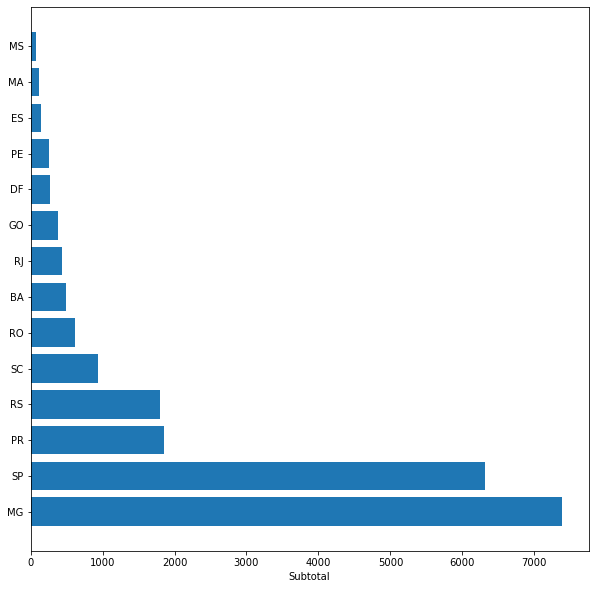

In [17]:
df.pipe(padronizacao_dados_geo).pipe(planilha_vendas).pipe(agregacao_por_estado, 
                                                           data_inicial='2021-04-01', 
                                                           data_final='2021-06-30',
                                                           save=True).pipe(benchmark_estados)

Media diária: 367.1907608695652


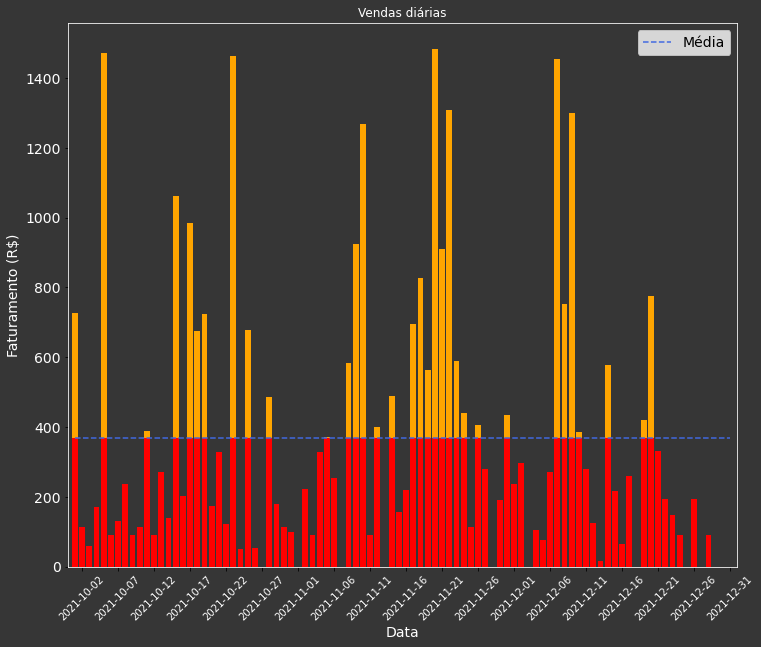

In [18]:
(df.pipe(padronizacao_dados_geo)
 .pipe(planilha_vendas).pipe(vendas_df)
 .pipe(analise_vendas_diarias, data_inicial='2021-10-01', data_final='2021-12-31', ticks=5, save=True))

(<Figure size 864x720 with 1 Axes>,
 <BarContainer object of 31 artists>,
 Text(0.5, 1.0, 'Faturamento por dia no ano de 2021'),
 Text(0, 0.5, 'Faturamento'),
 Text(0.5, 0, 'dia'))

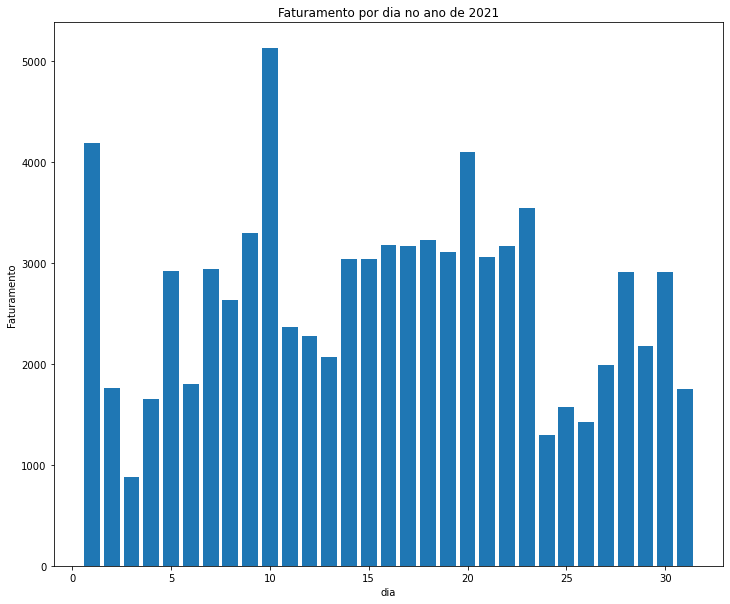

In [19]:
(df.pipe(padronizacao_dados_geo).pipe(planilha_vendas)
# .groupby('Data').agg({'Subtotal': ['sum', 'mean'],
#                      'Valor do Frete': 'mean'})).columns
 
.pipe(periodo_de_exercicio, ano=2021, periodo='dia'))

(<Figure size 720x720 with 1 Axes>, <BarContainer object of 21 artists>)

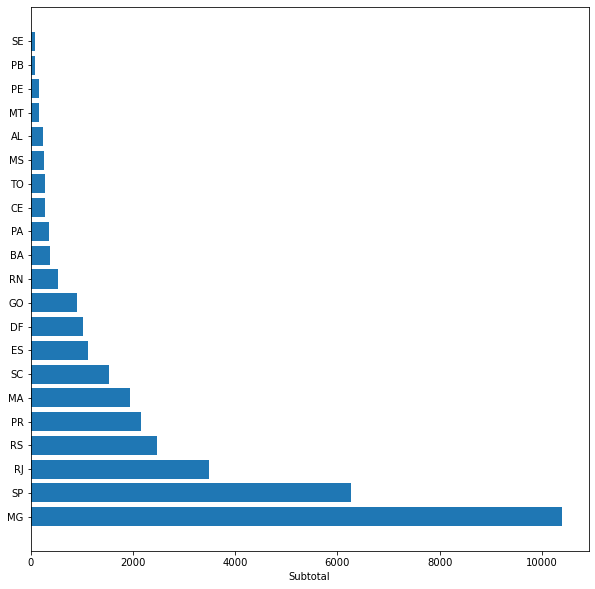

In [20]:
df.pipe(padronizacao_dados_geo).pipe(planilha_vendas).pipe(agregacao_por_estado,
                                                          data_inicial='2021-10-01',
                                                          data_final='2021-12-31').pipe(benchmark_estados, save=True)